In [286]:
%matplotlib inline
import pandas as pd
import numpy as np
import json
import xml.etree.ElementTree as et
import matplotlib.pyplot as plt
import scipy.stats as sc
import seaborn as sns
import geopandas as gp
from geopandas.tools import sjoin
from shapely.geometry import Point

In [2]:
tree = et.parse("../data/AviationData.xml")

In [3]:
root = tree.getroot()
#check the number of child element
len(root[0])

77257

In [5]:
#create a dataframe
events_list = [i.attrib for i in root[0]]
df_events = pd.DataFrame(events_list)
df_events.head()

,AccidentNumber,AirCarrier,AircraftCategory,AircraftDamage,AirportCode,AirportName,AmateurBuilt,BroadPhaseOfFlight,Country,EngineType,...,PublicationDate,PurposeOfFlight,RegistrationNumber,ReportStatus,Schedule,TotalFatalInjuries,TotalMinorInjuries,TotalSeriousInjuries,TotalUninjured,WeatherCondition
0,GAA15CA244,,,,,,,,United States,,...,,,N786AB,Preliminary,,,,,,
1,CEN15LA392,,Airplane,Substantial,IWS,WEST HOUSTON,No,LANDING,United States,,...,09/04/2015,Instructional,N452CS,Preliminary,,,,,2,VMC
2,GAA15CA246,,,,,,,,United States,,...,,,N112RP,Preliminary,,,,,,
3,GAA15CA243,,,,,,,,United States,,...,,,N8404X,Preliminary,,,,,,
4,GAA15CA242,,,,,,,,United States,,...,,,N5255G,Preliminary,,,,,,


## Clean-up

The dataframe has one major problem: empty cells from XML are stored as empty string instead of null. Timestamps are also still stored as string instead of datetime format.

In [6]:
df_events['EventDate'] = pd.to_datetime(df_events['EventDate'])
df_events['PublicationDate'] = pd.to_datetime(df_events['PublicationDate'])

In [8]:
#replace empty string with nan and calculate missing value
df_e = df_events.replace(r'^\s*$',np.nan, regex=True)
(len(df_e.index)-df_e.count())/len(df_e.index)*100

AccidentNumber           0.000000
AirCarrier              95.058053
AircraftCategory        78.616824
AircraftDamage           3.085805
AirportCode             43.724193
AirportName             38.735649
AmateurBuilt             0.846525
BroadPhaseOfFlight       8.060111
Country                  0.660134
EngineType               4.153669
EventDate                0.003883
EventId                  0.000000
FARDescription          78.429139
InjurySeverity           0.137204
InvestigationType        0.000000
Latitude                69.244211
Location                 0.104845
Longitude               69.255860
Make                     0.112611
Model                    0.148854
NumberOfEngines          5.075268
PublicationDate         17.070298
PurposeOfFlight          4.657183
RegistrationNumber       3.567314
ReportStatus             0.000000
Schedule                85.271238
TotalFatalInjuries      27.785185
TotalMinorInjuries      29.154640
TotalSeriousInjuries    30.434783
TotalUninjured

From the missing value table above, it is clear that not every variables are usable for meaningful analysis.
The subsequent dataset will be a subset of the original dataset based on 'Make' variable as it has very few missing values.

In [35]:
for i in list(df_e.columns):
    print i
    print df_e[i].value_counts()[:10]
    print "\n"

AccidentNumber
FTW82FRA19    1
ANC83FAA03    1
LAX85FA036    1
LAX85FA030    1
CHI84LA299    1
CHI89LA158    1
CHI89LA159    1
CHI89LA156    1
CHI89LA152    1
NYC96LA110    1
Name: AccidentNumber, dtype: int64


AirCarrier
UNITED AIRLINES                           49
AMERICAN AIRLINES                         41
CONTINENTAL AIRLINES                      25
USAIR                                     24
DELTA AIR LINES INC                       23
AMERICAN AIRLINES, INC.                   22
SOUTHWEST AIRLINES CO                     21
CONTINENTAL AIRLINES, INC.                19
UNITED AIR LINES INC                      14
SIMMONS AIRLINES (DBA: AMERICAN EAGLE)    12
Name: AirCarrier, dtype: int64


AircraftCategory
Airplane             14210
Helicopter            1775
Glider                 261
Balloon                120
Gyrocraft               62
Unknown                 40
Weight-Shift            20
Ultralight              18
Powered Parachute       10
Powered-Lift             2
Name: A

In [15]:
#list top 10 fatal crashes in USA 
df_e[(df_e.Country == 'United States')][['EventDate','Make','Model','TotalFatalInjuries']].sort_values(by='TotalFatalInjuries',ascending=False).head(10)

,EventDate,Make,Model,TotalFatalInjuries
25773,2001-09-11,Boeing,767-200ER,92
60320,1987-03-04,CASA,C-212-CC,9
10257,2009-08-08,PIPER,PA-32R-300,9
27311,2001-01-14,Beech,65-A90,9
10256,2009-08-08,EUROCOPTER,AS 350 BA,9
333,2015-06-25,DEHAVILLAND,DHC 3,9
66449,1985-02-04,BEECH,65-A80,9
34413,1997-10-08,Cessna,208B,9
12138,2008-08-05,SIKORSKY,S-61N,9
47667,1991-12-11,BEECH,400,9


Assumption: No value in TotalInjured variables doesn't always mean that it is zero as it can also means that it is unknown. Let's create a new variable storing the total number of people involved in each accident

In [159]:
#convert to numeric
df_e[['TotalFatalInjuries','TotalMinorInjuries','TotalSeriousInjuries','TotalUninjured']]=df_e[['TotalFatalInjuries','TotalMinorInjuries','TotalSeriousInjuries','TotalUninjured']].apply(pd.to_numeric)
#add TotalPerson variable
df_e['TotalPerson'] = df_e['TotalFatalInjuries'] + df_e['TotalSeriousInjuries'] + df_e['TotalMinorInjuries'] + df_e['TotalUninjured'] 

In [70]:
#Let's store percentage of injuries and fatalities on each accident
df_e['PctInjured'] = (df_e['TotalSeriousInjuries'] + df_e['TotalMinorInjuries']) / df_e['TotalPerson'] * 100
df_e['PctDeath'] = df_e['TotalFatalInjuries'] / df_e['TotalPerson'] * 100

In [71]:
print "Number of accidents in the dataset: " + str(len(df_e.index))
df_e[['TotalFatalInjuries','TotalMinorInjuries','TotalSeriousInjuries','TotalUninjured']].describe()

Number of accidents in the dataset: 77257
Date range: 1948-10-24 00:00:00 to 2015-09-01 00:00:00


C:\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,TotalFatalInjuries,TotalMinorInjuries,TotalSeriousInjuries,TotalUninjured
count,55791.000000,54733.000000,53744.000000,65862.000000
mean,0.788962,0.492555,0.309895,5.716817
std,6.087442,2.779814,1.368488,29.052413
min,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN
max,349.000000,380.000000,111.000000,699.000000


## Temporal & Spatial Dimension

In [140]:
print "Date range: " + str(df_e['EventDate'].min()) + " to " + str(df_e['EventDate'].max())

Date range: 1948-10-24 00:00:00 to 2015-09-01 00:00:00


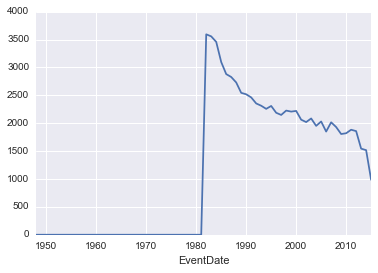

In [151]:
df_e['AccidentNumber'].groupby(df_e['EventDate'].map(lambda x: x.year)).count().plot()

In [155]:
df_e['AccidentNumber'].groupby(df_e['EventDate'].map(lambda x: x.year)).count().iloc[:10]

EventDate
1948.0       1
1962.0       1
1974.0       1
1977.0       1
1979.0       1
1981.0       1
1982.0    3593
1983.0    3556
1984.0    3457
1985.0    3096
Name: AccidentNumber, dtype: int64

While the dataset spans across 6 decades, seems like the first valid year is 1982 and goes up to 2015 (partial).

What about the location of the accidents?

In [208]:
print df_e['Country'].value_counts()[:10]

United States     73076
Canada              225
Mexico              197
Brazil              191
Bahamas             188
United Kingdom      188
Australia           178
France              153
Germany             143
Colombia            113
Name: Country, dtype: int64


In [209]:
print len(df_e['Country'].value_counts())

173


In [200]:
df_g = df_e[(df_e.Latitude>=0)&(df_e.Longitude>=0)]
df_g[['Latitude','Longitude']] = df_g[['Latitude','Longitude']].apply(pd.to_numeric)
geom = zip(df_g.Longitude, df_g.Latitude)
geometry = [Point(xy) for xy in geom]
geo_df = gp.GeoDataFrame(df_g, crs=None, geometry=geometry)

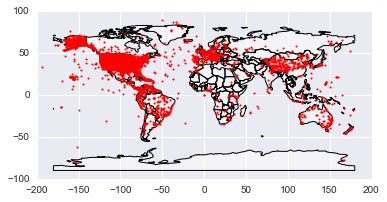

In [204]:
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white')
plt.figure(figsize=(20,10))
geo_df['geometry'].plot(ax=base, marker='o', color='red', markersize=2)

While the dataset covers accidents from 173 countries, 94% of the records are from United States. This, of course, does not necessarily reflect real-world numbers as NTSB focuses more on accidents happening in US soil.

The earth surface is 71% water, though, and emergency procedures on flights also emphasize on landing over water. How many crashes happens over water? 

In [296]:
ocean = gp.read_file('ocean.geojson')

ERROR:Fiona:CPLE_OpenFailed in Unable to open EPSG support file gcs.csv.
Try setting the GDAL_DATA environment variable to point to the
directory containing EPSG csv files.


In [302]:
ocean.head()

,featurecla,geometry,scalerank
0,Ocean,"(POLYGON ((180 84.0166204990001, 180 83.518005...",0


In [300]:
ocean_join = gp.tools.sjoin(geo_df, ocean, how="left", op='within')

In [305]:
ocean_join['IsOnWater']=np.where(ocean_join['featurecla']=="Ocean",1,0)

In [306]:
ocean_join['IsOnWater'].sum()

942

Only 942 incidents happens over water.

### Small Airplane vs Big Airplane

While for most people flying is associated with using scheduled commercial airline, a large number of flights are actually categorized as General Aviation (GA), ranging from small two-seaters small plane to large private jets. A large proportion of accidents covered this dataset actually involves single-engine propeller ("recirpocating") aicraft, comprising 73.9% of all accidents.

In [212]:
df_e['NumberOfEngines'] = df_e['NumberOfEngines'].astype(float)
pd.crosstab(df_e.EngineType,df_e.NumberOfEngines).applymap(lambda x: x*100.0/77257)

NumberOfEngines,0.0,1.0,2.0,3.0,4.0,18.0,24.0
EngineType,,,,,,,
Electric,0.000000,0.001294,0.000000,0.000000,0.000000,0.000000,0.000000
Hybrid Rocket,0.000000,0.001294,0.000000,0.000000,0.000000,0.000000,0.000000
None,0.003883,0.001294,0.001294,0.000000,0.000000,0.000000,0.000000
"REC, TJ, REC, TJ",0.000000,0.000000,0.000000,0.000000,0.001294,0.000000,0.000000
"REC, TJ, TJ",0.000000,0.000000,0.000000,0.000000,0.002589,0.000000,0.000000
Reciprocating,0.002589,73.927282,7.230413,0.006472,0.066013,0.001294,0.001294
"TF, TJ",0.000000,0.000000,0.003883,0.000000,0.000000,0.000000,0.000000
"TF, TJ, TJ",0.000000,0.000000,0.000000,0.001294,0.000000,0.000000,0.000000
"TJ, REC, REC, TJ",0.000000,0.000000,0.000000,0.000000,0.001294,0.000000,0.000000


Consistent with general aviation characteristic, most of these single-engine aircraft are overwhemingly used in personal and instructional flight, as pilots starts with small aircraft and move towards larger one through certification process.

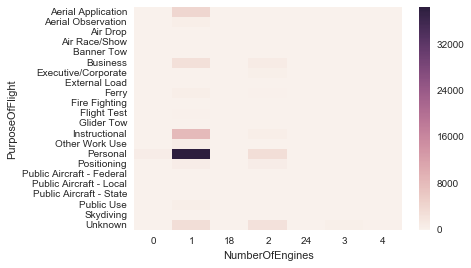

In [116]:
sns.heatmap(pd.crosstab(df_e.PurposeOfFlight,df_e.NumberOfEngines))

In fact, filtering the dataset just by those three criteria (single engine, reciprocating, and personal purpose) yield 37,866 records - 49% of the all the accidents.

In [213]:
len(df_e[(df_e.PurposeOfFlight=="Personal")&(df_e.NumberOfEngines == 1)&(df_e.EngineType=="Reciprocating")].index)*100.0/len(df_e.index)

49.013034417593225

Does that mean 51% of all accidents occurs on commercial flights which most people know and use to travel between cities?

The problem with the dataset is that it does not contain sufficient information to figure out such as crucial variables (e.g. FARdescription, Schedule) having very high missing values.

For the sake of familiarity, let's define commercial flights is one with multiple turbojet/turbofan engine. While we have Total Person variable, we cannot use it as there are fair number of missing value (25-30%) and it only represents number of people involved, not plane capacity.

In [221]:
len(df_e[(df_e.NumberOfEngines > 1)&(df_e.EngineType=="Turbo Fan")|(df_e.EngineType=="Turbo Jet")|(df_e.EngineType=="Turbo Prop")].index)

5663

There are 5,663 commercial flight in the dataset, representing 7.3% of all accidents.

In [229]:
## Create new variable
df_e['FlightType'] = np.where(((df_e.NumberOfEngines > 1)&(df_e.EngineType=="Turbo Fan")|(df_e.EngineType=="Turbo Jet")|(df_e.EngineType=="Turbo Prop")), 'Commercial', 'Non-commercial')

## Fatalities & Injuries

Let's assign severity based on the percentage of fatalities and injuries in each accident.

In [244]:
def pctlevel(x):
    #<20% = 0, 20-40% = 1, etc
    return x // 20

In [246]:
df_e['severity_fatal'] = df_e['PctDeath'].apply(lambda x : pctlevel(x))
df_e['severity_injured'] = df_e['PctInjured'].apply(lambda x : pctlevel(x))

In [250]:
pd.crosstab(df_e.FlightType,df_e.severity_fatal).apply(lambda x: x*100/x.sum(),axis=1)

severity_fatal,0.0,1.0,2.0,3.0,4.0,5.0
FlightType,,,,,,
Commercial,84.277127,0.980702,1.075609,0.411262,0.442898,12.812401
Non-commercial,80.762569,0.763424,1.888245,0.588072,0.102645,15.895045


In [251]:
pd.crosstab(df_e.FlightType,df_e.severity_injured).apply(lambda x: x*100/x.sum(),axis=1)

severity_injured,0.0,1.0,2.0,3.0,4.0,5.0
FlightType,,,,,,
Commercial,88.421386,2.435938,1.739956,1.012338,0.442898,5.947485
Non-commercial,70.673396,2.187627,4.670359,1.383572,0.211706,20.873340


What is the most dangerous phase of flight?

In [253]:
ct = pd.crosstab(df_e.BroadPhaseOfFlight,df_e.severity_fatal).apply(lambda x: x*100/x.sum(),axis=1)
ct

severity_fatal,0.0,1.0,2.0,3.0,4.0,5.0
BroadPhaseOfFlight,,,,,,
APPROACH,76.522574,1.075889,2.593660,0.864553,0.211335,18.731988
CLIMB,70.248937,1.275046,2.550091,1.153613,0.182149,24.590164
CRUISE,72.976896,0.689488,1.717673,0.762066,0.108867,23.745010
DESCENT,76.007931,0.925314,1.454065,0.660939,0.198282,20.753470
GO-AROUND,80.708295,1.025163,2.236719,1.304753,0.093197,14.631873
LANDING,98.303091,0.285618,0.478831,0.050403,0.016801,0.865255
MANEUVERING,61.844928,0.873429,3.892124,0.582286,0.107263,32.699969
OTHER,58.163265,2.040816,4.081633,0.000000,0.000000,35.714286
STANDING,90.660920,3.017241,3.735632,0.000000,0.143678,2.442529


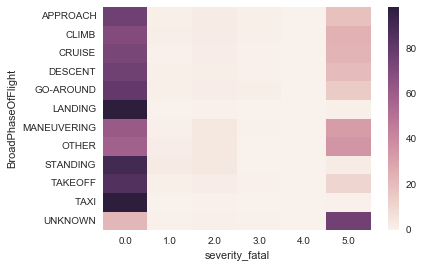

In [254]:
sns.heatmap(ct)

In [57]:
ct = pd.crosstab(df_e.BroadPhaseOfFlight,df_e.AircraftDamage).apply(lambda x: x / x.sum()*100, axis=1)
ct

AircraftDamage,Destroyed,Minor,Substantial
BroadPhaseOfFlight,,,
APPROACH,26.896927,2.719608,70.383465
CLIMB,37.656100,6.147935,56.195965
CRUISE,33.554688,2.333984,64.111328
DESCENT,29.441624,4.111675,66.446701
GO-AROUND,27.103404,0.963391,71.933205
LANDING,4.277811,2.426467,93.295722
MANEUVERING,40.383393,0.709595,58.907011
OTHER,29.927007,14.598540,55.474453
STANDING,10.876452,18.585005,70.538543


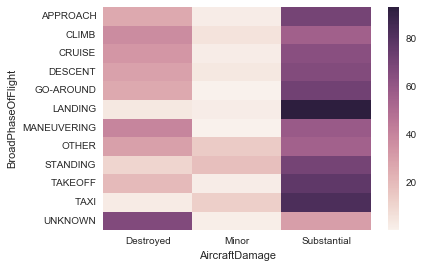

In [58]:
sns.heatmap(ct)

In [269]:
ct = pd.crosstab(df_e.AircraftDamage,df_e.severity_fatal).apply(lambda x: x / x.sum()*100, axis=1)
ct

severity_fatal,0.0,1.0,2.0,3.0,4.0,5.0
AircraftDamage,,,,,,
Destroyed,37.350225,1.923224,4.548577,1.816378,0.442647,53.918950
Minor,95.839210,1.198872,2.397743,0.211566,0.000000,0.352609
Substantial,96.646235,0.283129,0.753065,0.134267,0.011675,2.171629
